Suggestions for imporving dataset features:
1. Increase diversity of features: expand industry categories, introduce new metrics (project completion rate, number of patents, revenue, geographical presence etc.)
2. Refine strength categories: specific criteria for each strenght level to reduce subjectivity
3. Feature engineering: interaction features that capture interactions between different fields (e.g. combined expertise in ML and NLP)
4. Dimensionality reduction: PCA or UMAP
5. Add loggs

Dataset can incorporate internal company features as follows:
1. Instead of Publication Rate, Industry Orientation etc. modify features in the form "Need for publications/industry collaborations/ members etc. so that interpretation of strengths and weaknesses is uniform.

In [58]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture


In [50]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [54]:
!pip install umap

In [53]:
!pip install kneed
from kneed import KneeLocator

In [71]:
expanded_involvement_columns = ['Security', 'Humanities', 'Nat. Sci', 'Health', 'AI Ethics', 'Big Data', 
                                'Robotics', 'Documents', 'Multimedia', 'NLP', 'KRR', 'Graphs', 'DL/ML', 
                                'Funding', 'Application-Oriented', 'Cybersecurity', 'Biotech', 
                                'FinTech', 'Agritech', 'MedTech', 'ClimateTech', 'EdTech', 
                                'Renewable Energy', 'Telecom', 'E-commerce']
granular_strength_map = {f'Level {i}': i for i in range(11)}

In [10]:
def standardize_data(data):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

Hyperparameter Optimization
-Adjusting encoding dimension
-Learning Rate and Epochs
-Additional Layers

In [11]:
def create_autoencoder(input_dim, encoding_dim, layer_sizes, dropout_rate=0.2):
    input_layer = Input(shape=(input_dim,), name='input_layer')
    x = input_layer
    
    # Add encoder layers
    for size in layer_sizes:
        x = Dense(size)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(dropout_rate)(x)
    
    encoded = Dense(encoding_dim, activation='relu', name='encoded_layer')(x)
    
    # Add decoder layers (reverse of encoder)
    for size in reversed(layer_sizes):
        x = Dense(size)(encoded)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(dropout_rate)(x)
    
    decoded = Dense(input_dim, activation='sigmoid')(x)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return autoencoder


In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def train_autoencoder(autoencoder, train_data, val_data, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    
    history = autoencoder.fit(train_data, train_data,
                              validation_data=(val_data, val_data),
                              epochs=epochs, batch_size=batch_size, shuffle=True, verbose=2,
                              callbacks=[early_stopping, reduce_lr])
    
    return history.history['loss'], history.history['val_loss']



In [13]:
def get_encoded_data(autoencoder, data):
    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded_layer').output)
    return encoder_model.predict(data)


In [14]:
def apply_agglomerative_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    return clustering.fit_predict(data)

In [15]:
def apply_kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans.fit(data)
    return kmeans.labels_

In [59]:
def apply_gmm_clustering(data, n_clusters):
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(data)
    return gmm.predict(data)

In [16]:
def apply_dbscan_clustering(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(data)

In [17]:
def evaluate_clustering(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    return silhouette_avg, davies_bouldin

In [18]:
def find_optimal_clusters(data, clustering_func, cluster_range):
    silhouette_scores = []
    davies_bouldin_scores = []
    inertia_scores = []

    for n_clusters in cluster_range:
        labels = clustering_func(data, n_clusters)
        silhouette_avg = silhouette_score(data, labels)
        davies_bouldin_avg = davies_bouldin_score(data, labels)
        
        # Assuming KMeans for inertia
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
        inertia_scores.append(kmeans.inertia_)
        
        silhouette_scores.append(silhouette_avg)
        davies_bouldin_scores.append(davies_bouldin_avg)
    
    # Debug prints to understand the scores
    print(f'Silhouette Scores: {silhouette_scores}')
    print(f'Davies-Bouldin Scores: {davies_bouldin_scores}')
    print(f'Inertia Scores: {inertia_scores}')
    
    # Use KneeLocator to find the elbow point in inertia scores
    try:
        kneedle = KneeLocator(cluster_range, inertia_scores, curve='convex', direction='decreasing')
        elbow_point = kneedle.elbow
        if elbow_point is None:
            raise ValueError('Elbow point not found.')
    except ValueError as e:
        print(f'Error finding elbow point: {e}')
        # Fallback: use the number of clusters with the best silhouette score
        elbow_point = cluster_range[np.argmax(silhouette_scores)]
        print(f'Fallback to the best silhouette score: {elbow_point}')
    
    optimal_clusters = elbow_point
    print(f'Optimal number of clusters determined: {optimal_clusters}')
    return optimal_clusters


In [19]:
def visualize_clusters(data, labels, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method not recognized: choose 'pca', or 'tsne'")
        
    reduced_data = reducer.fit_transform(data)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
    plt.title(f'Clusters visualization using {method.upper()}')
    plt.show()

In [23]:
def train_multiple_autoencoders(num_autoencoders, input_dim, best_params, data):
    autoencoders = []
    histories = []
    for _ in range(num_autoencoders):
        autoencoder = create_autoencoder(
            input_dim=input_dim,
            encoding_dim=best_params['encoding_dim'],
            layer_sizes=best_params['layer_sizes'],
            dropout_rate=best_params['dropout_rate']
        )
        history = train_autoencoder(autoencoder, data, data, epochs=best_params['epochs'], batch_size=best_params['batch_size'])
        autoencoders.append(autoencoder)
        histories.append(history)
    return autoencoders, histories


In [24]:
def plot_training_history(histories):
    avg_train_loss = np.mean([h[0] for h in histories], axis=0)
    avg_val_loss = np.mean([h[1] for h in histories], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_loss, label='Average Training Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()


In [25]:
def ensemble_encoding(autoencoders, data):
    encoded_representations = [get_encoded_data(autoencoder, data) for autoencoder in autoencoders]
    combined_encoding = np.mean(encoded_representations, axis=0)
    return combined_encoding

In [27]:
def autoencoder_func(num_autoencoders, input_dim, best_params, data):
    return train_multiple_autoencoders(num_autoencoders, input_dim, best_params, data)

In [87]:
def load_and_preprocess_data(file_path):
    # Load the dataset
    data = pd.read_csv(file_path, index_col=0).transpose()
    data = data.replace(granular_strength_map).infer_objects(copy=False)
    
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(0, inplace=True)
    
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    
    return data_scaled

In [88]:
file_path = 'data/new_synthetic_data.csv'
preprocessed_data = load_and_preprocess_data(file_path)

preprocessed_data.head()

/var/folders/fm/9tf79c_d1691c4jwk2qqr42m0000gn/T/ipykernel_58578/3828349613.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(granular_strength_map).infer_objects(copy=False)


,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,...,Cybersecurity,Biotech,FinTech,Agritech,MedTech,ClimateTech,EdTech,Renewable Energy,Telecom,E-commerce
Team_0,-1.239841,0.341795,-0.629192,-1.573189,1.562427,-1.293851,1.568318,0.980011,0.325381,0.583654,...,-0.958007,-0.607981,0.268653,0.335345,-0.049664,0.934229,-1.251490,-1.355702,0.675313,-0.309804
Team_1,-1.239841,-0.289989,0.314596,-0.639730,-1.569945,-0.976030,-0.903908,1.628166,-0.315764,-1.326834,...,-1.606623,1.586896,-0.686274,1.626374,0.578998,-1.633215,0.645665,-1.032454,0.675313,0.948283
Team_2,0.044636,1.605363,-0.314596,-0.017425,-0.316996,-0.658208,-1.212936,-1.288533,-1.598054,0.583654,...,0.014918,0.646235,1.541888,-0.632927,1.521992,-0.670424,-0.302912,1.230282,-1.546112,-0.938848
Team_3,1.650231,-1.237664,-0.629192,-0.639730,-0.316996,-1.611673,-0.903908,0.007778,-1.277481,-0.053175,...,0.014918,1.273342,-1.004583,-0.632927,-0.678327,0.292368,-1.251490,-0.062710,0.675313,1.262805
Team_4,1.007993,-1.237664,-1.258384,-1.262036,-0.316996,-0.340387,-0.594879,0.655933,-0.956909,-0.053175,...,0.014918,-0.921535,0.268653,-1.278442,1.521992,-1.633215,0.013280,-1.678950,0.357967,0.319240


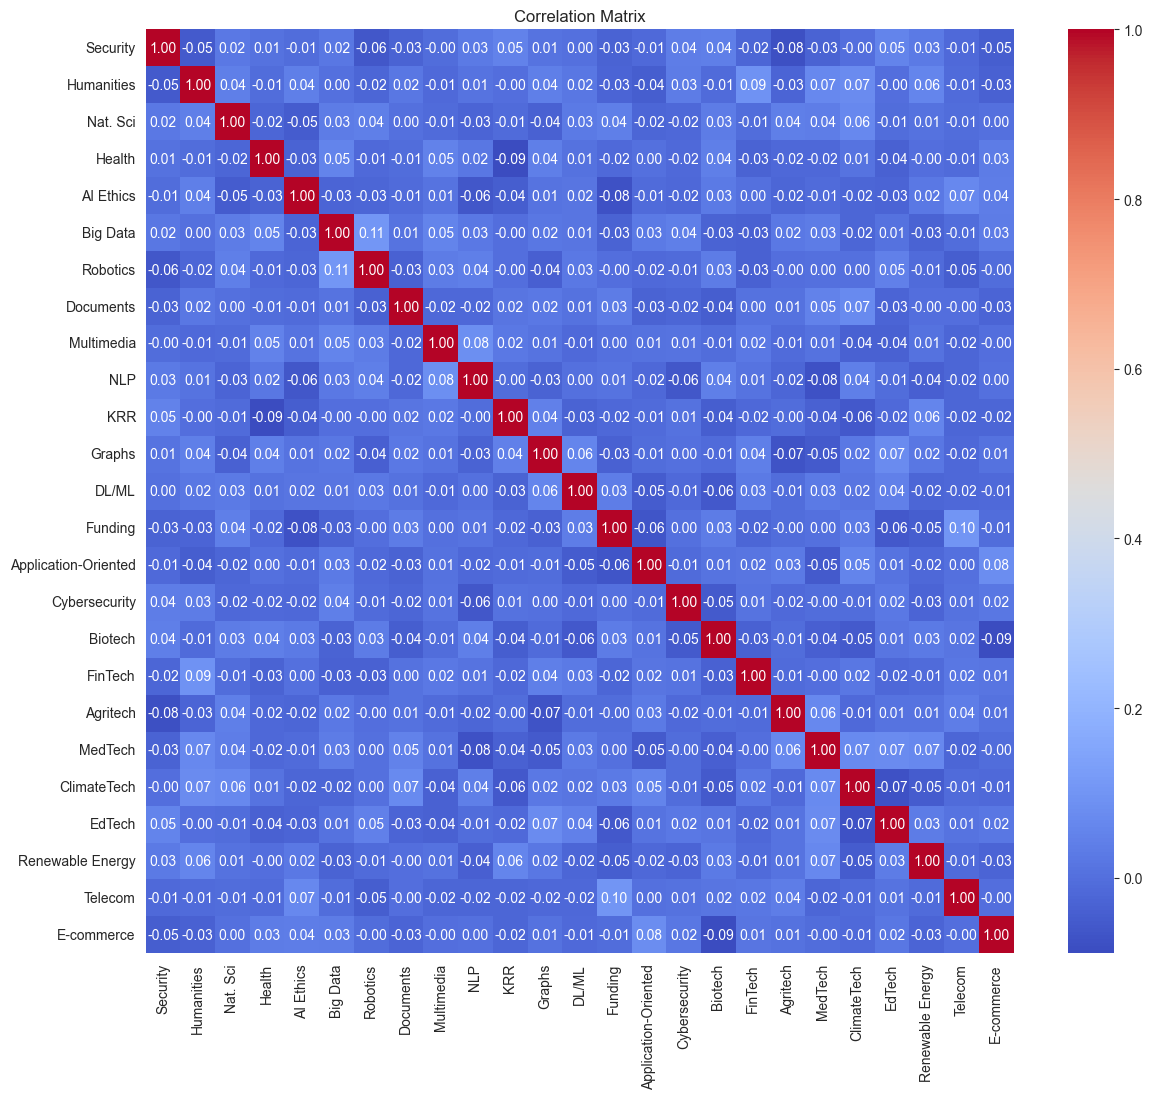

In [89]:
# Calculate correlation matrix
correlation_matrix = preprocessed_data.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [95]:
def get_highly_correlated_pairs(correlation_matrix, threshold=0.1):
    correlated_pairs = []
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            if abs(correlation_matrix.iloc[i,j]) >= threshold and (i != j):
                correlated_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
    return correlated_pairs

highly_correlated_pairs = get_highly_correlated_pairs(correlation_matrix)
for pair in highly_correlated_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")

Big Data - Robotics: 0.11
Robotics - Big Data: 0.11
Funding - Telecom: 0.10
Telecom - Funding: 0.10


In [45]:
def add_interaction_features(data): 
    #FIXME: Refine interaction terms. This is a baseline implementation with no real insights into what industry terms should interact. Interaction will depend on the specific needs of the user.
    
    # Create a new DataFrame to store the aggregate features for each team
    aggregate_features = pd.DataFrame(index=data.index)
    
    aggregate_features['AI_Health_Interaction'] = data['AI Ethics'] * data['Health']
    aggregate_features['AI_BigData_Interaction'] = data['AI Ethics'] * data['Big Data']
    aggregate_features['Health_NatSci_Interaction'] = data['Health'] * data['Nat. Sci']
    aggregate_features['Robotics_Documents_Interaction'] = data['Robotics'] * data['Documents']
    aggregate_features['NLP_KRR_Interaction'] = data['NLP'] * data['KRR']
    aggregate_features['Graphs_DLML_Interaction'] = data['Graphs'] * data['DL/ML']

    # Sum interaction features
    aggregate_features['AI_BigData_Sum'] = data['AI Ethics'] + data['Big Data']
    aggregate_features['Health_NatSci_Sum'] = data['Health'] + data['Nat. Sci']

    # Difference interaction features
    aggregate_features['AI_BigData_Diff'] = data['AI Ethics'] - data['Big Data']
    aggregate_features['Health_NatSci_Diff'] = data['Health'] - data['Nat. Sci']


    return aggregate_features

In [76]:
# Add interaction features to the preprocessed data
interaction_features = add_interaction_features(preprocessed_data)

In [77]:
# Combine the interaction features with the original preprocessed data
combined_data = pd.concat([preprocessed_data, interaction_features], axis=1)

combined_data.head()

,Security,Humanities,Nat. Sci,Health,AI Ethics,Big Data,Robotics,Documents,Multimedia,NLP,...,AI_Health_Interaction,AI_BigData_Interaction,Health_NatSci_Interaction,Robotics_Documents_Interaction,NLP_KRR_Interaction,Graphs_DLML_Interaction,AI_BigData_Sum,Health_NatSci_Sum,AI_BigData_Diff,Health_NatSci_Diff
Team_0,-1.239841,0.341795,-0.629192,-1.573189,1.562427,-1.293851,1.568318,0.980011,0.325381,0.583654,...,-2.457993,-2.021549,0.989838,1.536969,0.951257,-1.972398,0.268576,-2.202381,2.856279,-0.943996
Team_1,-1.239841,-0.289989,0.314596,-0.639730,-1.569945,-0.976030,-0.903908,1.628166,-0.315764,-1.326834,...,1.004341,1.532313,-0.201257,-1.471712,-2.162514,-1.172438,-2.545975,-0.325134,-0.593915,-0.954326
Team_2,0.044636,1.605363,-0.314596,-0.017425,-0.316996,-0.658208,-1.212936,-1.288533,-1.598054,0.583654,...,0.005524,0.208649,0.005482,1.562907,0.761423,-1.176180,-0.975204,-0.332021,0.341212,0.297172
Team_3,1.650231,-1.237664,-0.629192,-0.639730,-0.316996,-1.611673,-0.903908,0.007778,-1.277481,-0.053175,...,0.202792,0.510894,0.402513,-0.007030,-0.000190,0.951498,-1.928669,-1.268922,1.294677,-0.010538
Team_4,1.007993,-1.237664,-1.258384,-1.262036,-0.316996,-0.340387,-0.594879,0.655933,-0.956909,-0.053175,...,0.400060,0.107901,1.588126,-0.390201,-0.000190,1.273628,-0.657383,-2.520420,0.023391,-0.003651


In [82]:
#Dimenstionality Reduction to identify most relevant features
pca = PCA(n_components=0.95)
pca.fit(combined_data)

important_features = np.argsort(np.abs(pca.components_).sum(axis=0))[-10:]
important_feature_names = combined_data.columns[important_features]


print("Important features identified by PCA:", important_feature_names)

Important features identified by PCA: Index(['Documents', 'NLP', 'Graphs', 'AI_BigData_Interaction', 'Robotics',
       'Renewable Energy', 'KRR', 'Telecom', 'NLP_KRR_Interaction', 'FinTech'],
      dtype='object')


In [47]:
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42)
input_dim = train_data.shape[1]

# Additional validation split from training data
train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)


In [48]:
param_grid = {
    'layer_sizes': [[128, 64], [64, 32], [32, 16]],
    'encoding_dim': [8, 16, 32],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

In [55]:
from sklearn.model_selection import ParameterGrid

# Create a parameter grid
param_combinations = list(ParameterGrid(param_grid))

best_score = -1
best_params = None

for params in param_combinations:
    print(f"Testing with params: {params}")
    
    # Create and train the autoencoder
    autoencoder = create_autoencoder(input_dim, params['encoding_dim'], params['layer_sizes'], params['dropout_rate'])
    
    # Train the autoencoder
    history = train_autoencoder(autoencoder, train_data_split, val_data_split, epochs=params['epochs'], batch_size=params['batch_size'])
    
    # Get encoded data
    encoded_data = get_encoded_data(autoencoder, test_data)
    
    # Find optimal clusters
    optimal_clusters = find_optimal_clusters(encoded_data, apply_kmeans_clustering, range(2, 11))
    best_labels_kmeans = apply_kmeans_clustering(encoded_data, optimal_clusters)
    
    # Evaluate clustering
    silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(encoded_data, best_labels_kmeans)
    
    if silhouette_avg_kmeans > best_score:
        best_score = silhouette_avg_kmeans
        best_params = params
        print(f"New best score: {best_score} with params: {best_params}")

print(f"Best parameters found: {best_params} with silhouette score: {best_score}")


Testing with params: {'batch_size': 32, 'dropout_rate': 0.2, 'encoding_dim': 8, 'epochs': 50, 'layer_sizes': [128, 64]}
Epoch 1/50
20/20 - 2s - 91ms/step - loss: 1.3197 - val_loss: 1.3678 - learning_rate: 0.0010
Epoch 2/50
20/20 - 0s - 5ms/step - loss: 1.1879 - val_loss: 1.3049 - learning_rate: 0.0010
Epoch 3/50
20/20 - 0s - 3ms/step - loss: 1.1133 - val_loss: 1.2404 - learning_rate: 0.0010
Epoch 4/50
20/20 - 0s - 3ms/step - loss: 1.0700 - val_loss: 1.1834 - learning_rate: 0.0010
Epoch 5/50
20/20 - 0s - 4ms/step - loss: 1.0418 - val_loss: 1.1368 - learning_rate: 0.0010
Epoch 6/50
20/20 - 0s - 4ms/step - loss: 1.0227 - val_loss: 1.0995 - learning_rate: 0.0010
Epoch 7/50
20/20 - 0s - 3ms/step - loss: 1.0047 - val_loss: 1.0722 - learning_rate: 0.0010
Epoch 8/50
20/20 - 0s - 3ms/step - loss: 0.9944 - val_loss: 1.0512 - learning_rate: 0.0010
Epoch 9/50
20/20 - 0s - 2ms/step - loss: 0.9849 - val_loss: 1.0352 - learning_rate: 0.0010
Epoch 10/50
20/20 - 0s - 2ms/step - loss: 0.9802 - val_loss:

In [60]:
final_autoencoders, final_histories = train_multiple_autoencoders(3, input_dim, best_params, train_data)

Epoch 1/100
13/13 - 2s - 119ms/step - loss: 1.3986 - val_loss: 1.3589 - learning_rate: 0.0010
Epoch 2/100
13/13 - 0s - 3ms/step - loss: 1.3641 - val_loss: 1.3469 - learning_rate: 0.0010
Epoch 3/100
13/13 - 0s - 3ms/step - loss: 1.3370 - val_loss: 1.3335 - learning_rate: 0.0010
Epoch 4/100
13/13 - 0s - 3ms/step - loss: 1.3096 - val_loss: 1.3181 - learning_rate: 0.0010
Epoch 5/100
13/13 - 0s - 3ms/step - loss: 1.2842 - val_loss: 1.3006 - learning_rate: 0.0010
Epoch 6/100
13/13 - 0s - 5ms/step - loss: 1.2614 - val_loss: 1.2819 - learning_rate: 0.0010
Epoch 7/100
13/13 - 0s - 4ms/step - loss: 1.2408 - val_loss: 1.2611 - learning_rate: 0.0010
Epoch 8/100
13/13 - 0s - 3ms/step - loss: 1.2197 - val_loss: 1.2398 - learning_rate: 0.0010
Epoch 9/100
13/13 - 0s - 3ms/step - loss: 1.1997 - val_loss: 1.2183 - learning_rate: 0.0010
Epoch 10/100
13/13 - 0s - 3ms/step - loss: 1.1799 - val_loss: 1.1970 - learning_rate: 0.0010
Epoch 11/100
13/13 - 0s - 3ms/step - loss: 1.1640 - val_loss: 1.1759 - learni

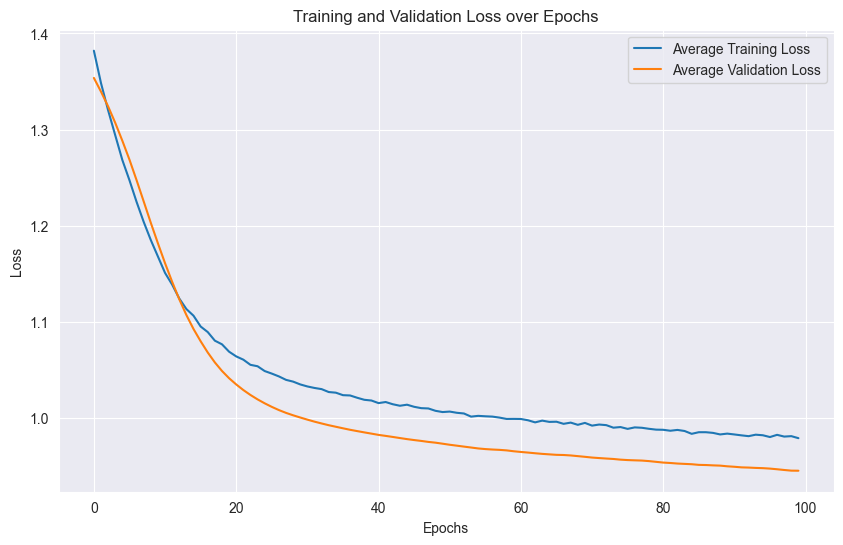

In [61]:
plot_training_history(final_histories)

In [62]:
final_combined_encoding = ensemble_encoding(final_autoencoders, test_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [63]:
def compute_cluster_statistics(data, labels):

    data_with_labels = data.copy()
    data_with_labels['Cluster'] = labels
    
    cluster_stats = data_with_labels.groupby('Cluster').mean()
    
    return cluster_stats

In [64]:
def plot_cluster_statistics(cluster_stats, title='Cluster Statistics'):
    plt.figure(figsize=(20, 12))  # Increase the figure size for better readability
    
    # Set vmin and vmax for better color scaling
    vmin = cluster_stats.min().min()
    vmax = cluster_stats.max().max()
    
    sns.heatmap(cluster_stats, annot=True, fmt='.2f', cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to fit everything in the figure area
    plt.show()

In [66]:
optimal_clusters_kmeans = find_optimal_clusters(final_combined_encoding, apply_kmeans_clustering, range(2, 11))
best_labels_kmeans = apply_kmeans_clustering(final_combined_encoding, optimal_clusters_kmeans)
silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(final_combined_encoding, best_labels_kmeans)
print(f'Test Set - KMeans Silhouette Score: {silhouette_avg_kmeans}, Davies-Bouldin Score: {davies_bouldin_kmeans}')


Silhouette Scores: [0.25699395, 0.2841519, 0.1748848, 0.20468692, 0.18184467, 0.24305296, 0.20989998, 0.22922856, 0.20269173]
Davies-Bouldin Scores: [1.5743018074683348, 1.2361990313913704, 1.6721915130689244, 1.4795944876902936, 1.5247068059744133, 1.2460501806666304, 1.3319967450994228, 1.2321782229416363, 1.3478432557960116]
Inertia Scores: [321.1297607421875, 237.51412963867188, 223.56280517578125, 194.58905029296875, 182.252685546875, 147.07003784179688, 145.34727478027344, 131.04241943359375, 129.5844268798828]
Optimal number of clusters determined: 7
Test Set - KMeans Silhouette Score: 0.24305295944213867, Davies-Bouldin Score: 1.2460501806666304


In [67]:
optimal_clusters_agg = find_optimal_clusters(final_combined_encoding, apply_agglomerative_clustering, range(2, 11))
best_labels_agg = apply_agglomerative_clustering(final_combined_encoding, optimal_clusters_agg)
silhouette_avg_agg, davies_bouldin_agg = evaluate_clustering(final_combined_encoding, best_labels_agg)
print(f'Test Set - Agglomerative Silhouette Score: {silhouette_avg_agg}, Davies-Bouldin Score: {davies_bouldin_agg}')

Silhouette Scores: [0.23792237, 0.22778286, 0.21315832, 0.24393165, 0.2070861, 0.20512697, 0.21962376, 0.21731423, 0.2185536]
Davies-Bouldin Scores: [1.6622021712430683, 1.3289544561994242, 1.4296381606029336, 1.2064889966167671, 1.3966076514654973, 1.331804150416747, 1.2639110752115164, 1.2166946669755438, 1.208953545916233]
Inertia Scores: [321.1297607421875, 237.51412963867188, 223.56280517578125, 194.58905029296875, 182.252685546875, 147.07003784179688, 145.34727478027344, 131.04241943359375, 129.5844268798828]
Optimal number of clusters determined: 7
Test Set - Agglomerative Silhouette Score: 0.20512697100639343, Davies-Bouldin Score: 1.331804150416747


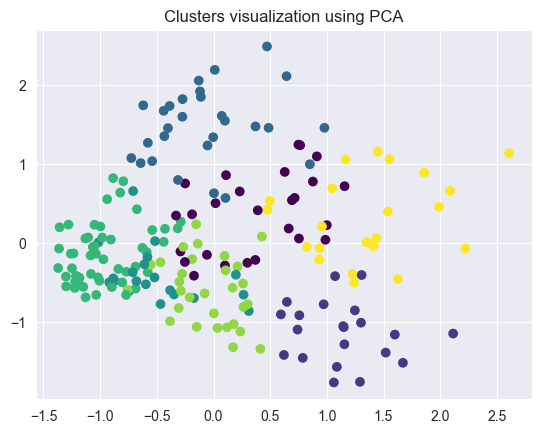

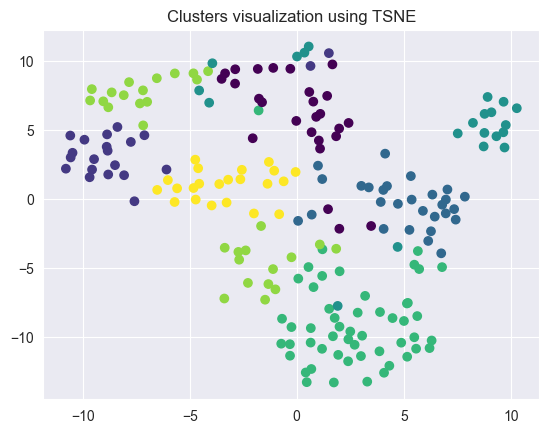

In [68]:
visualize_clusters(final_combined_encoding, best_labels_kmeans, method='pca')
visualize_clusters(final_combined_encoding, best_labels_kmeans, method='tsne')

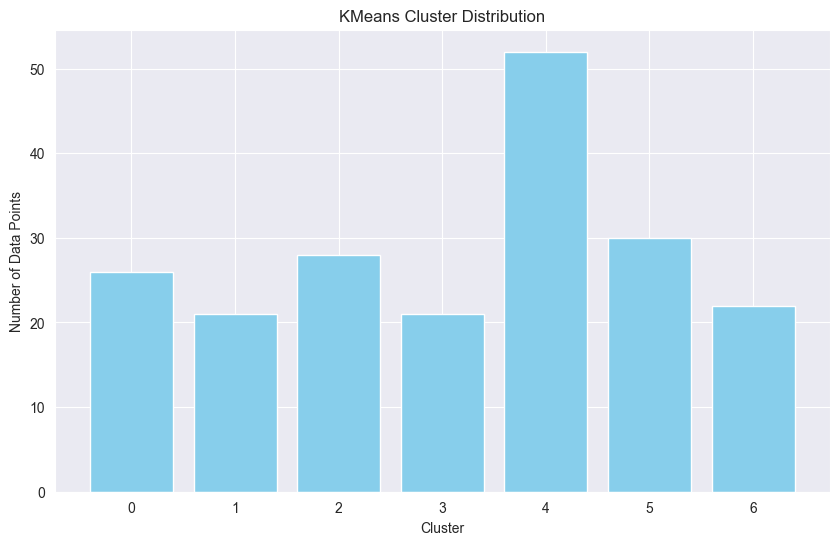

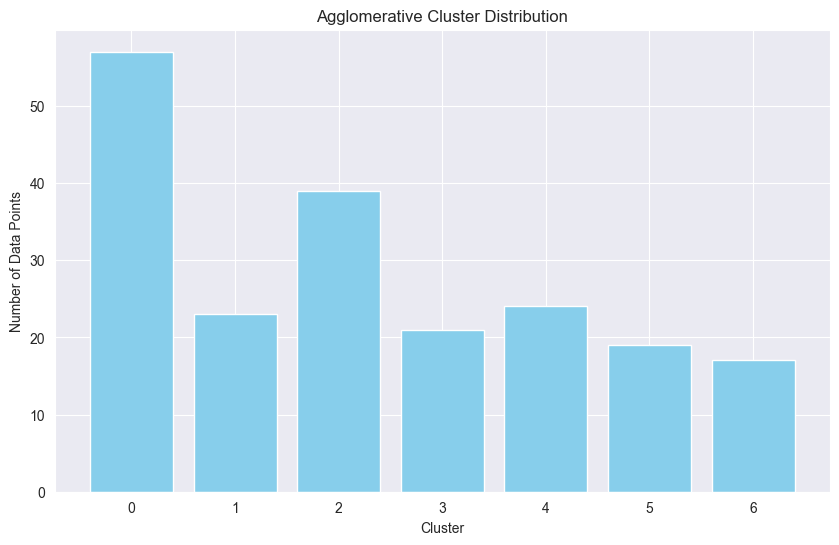

In [69]:
def plot_class_distribution(labels, title='Cluster Distribution'):
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    
    plt.figure(figsize=(10, 6))
    plt.bar(distribution.keys(), distribution.values(), color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Data Points')
    plt.title(title)
    plt.show()

# Assuming best_labels_kmeans contains the labels for the clusters
plot_class_distribution(best_labels_kmeans, title='KMeans Cluster Distribution')

# Assuming best_labels_agg contains the labels for the clusters
plot_class_distribution(best_labels_agg, title='Agglomerative Cluster Distribution')


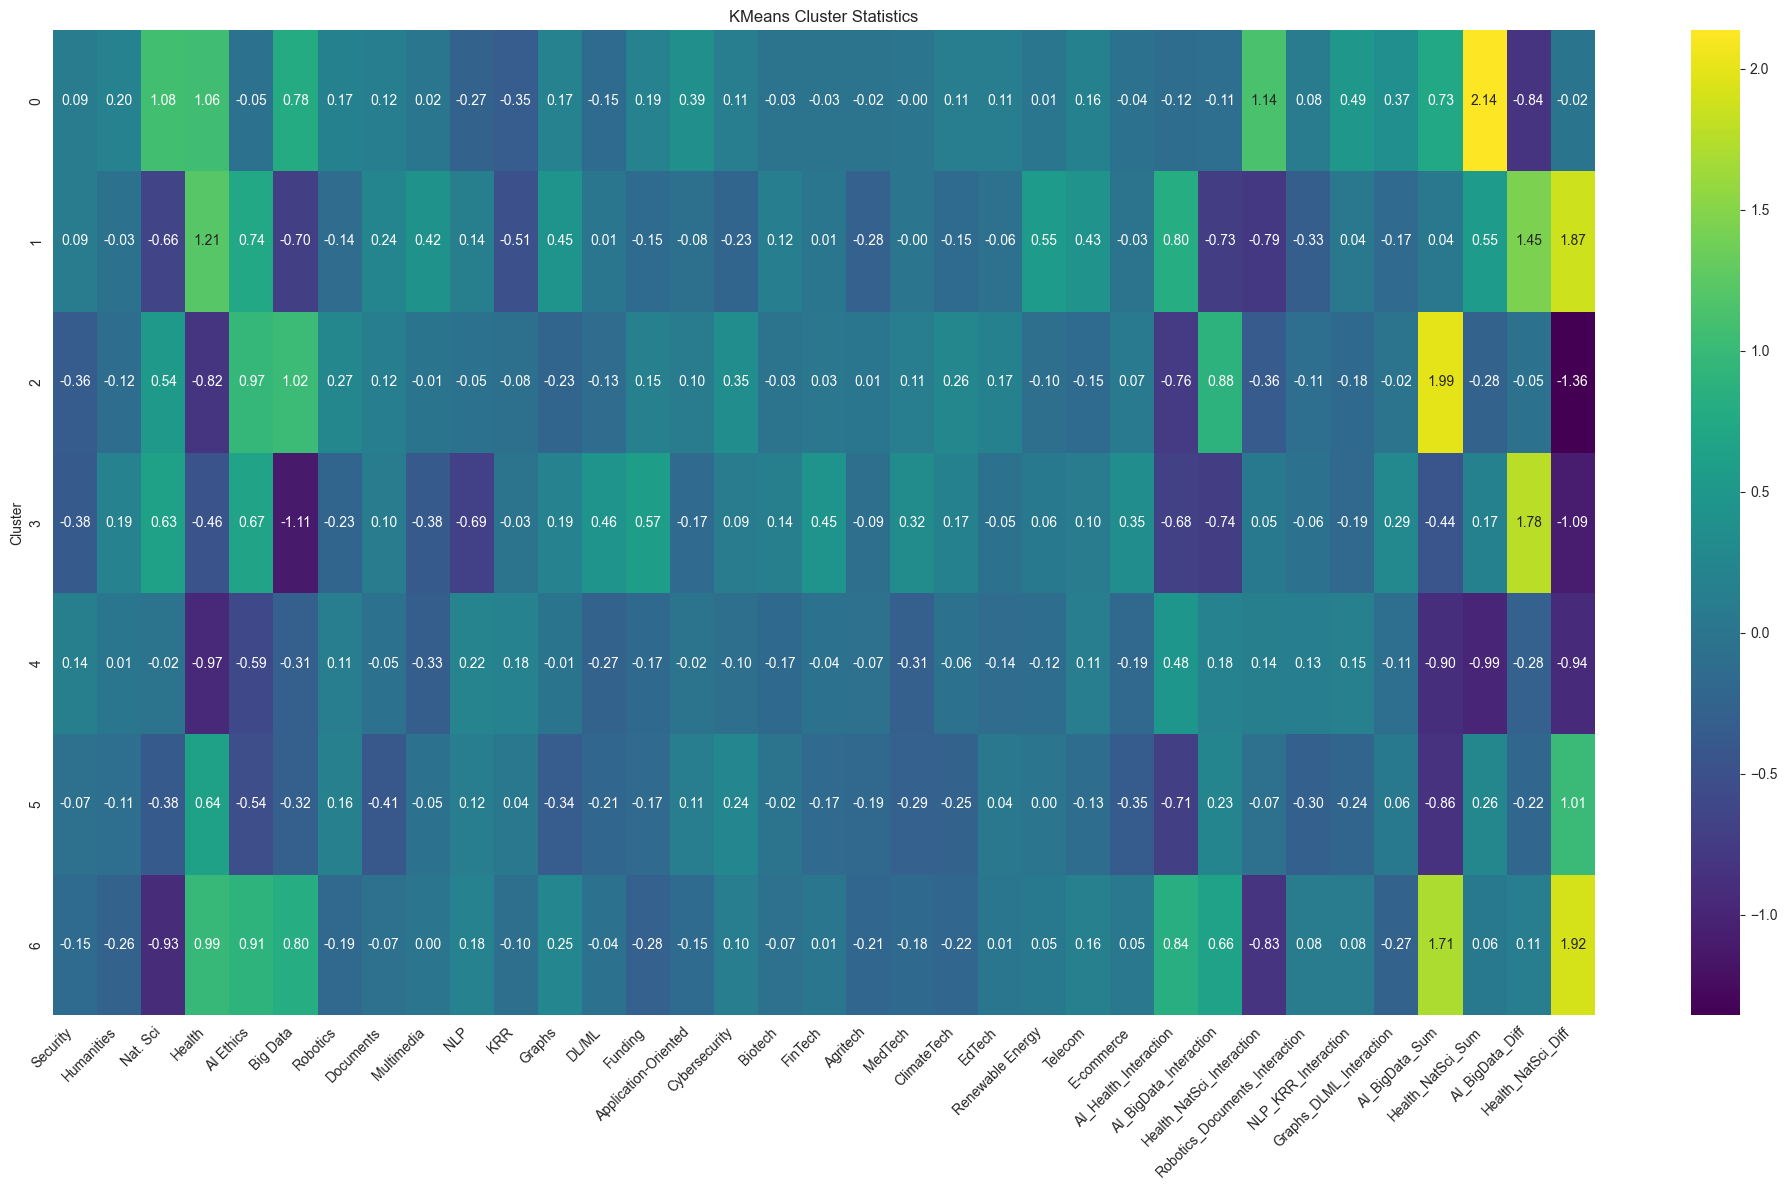

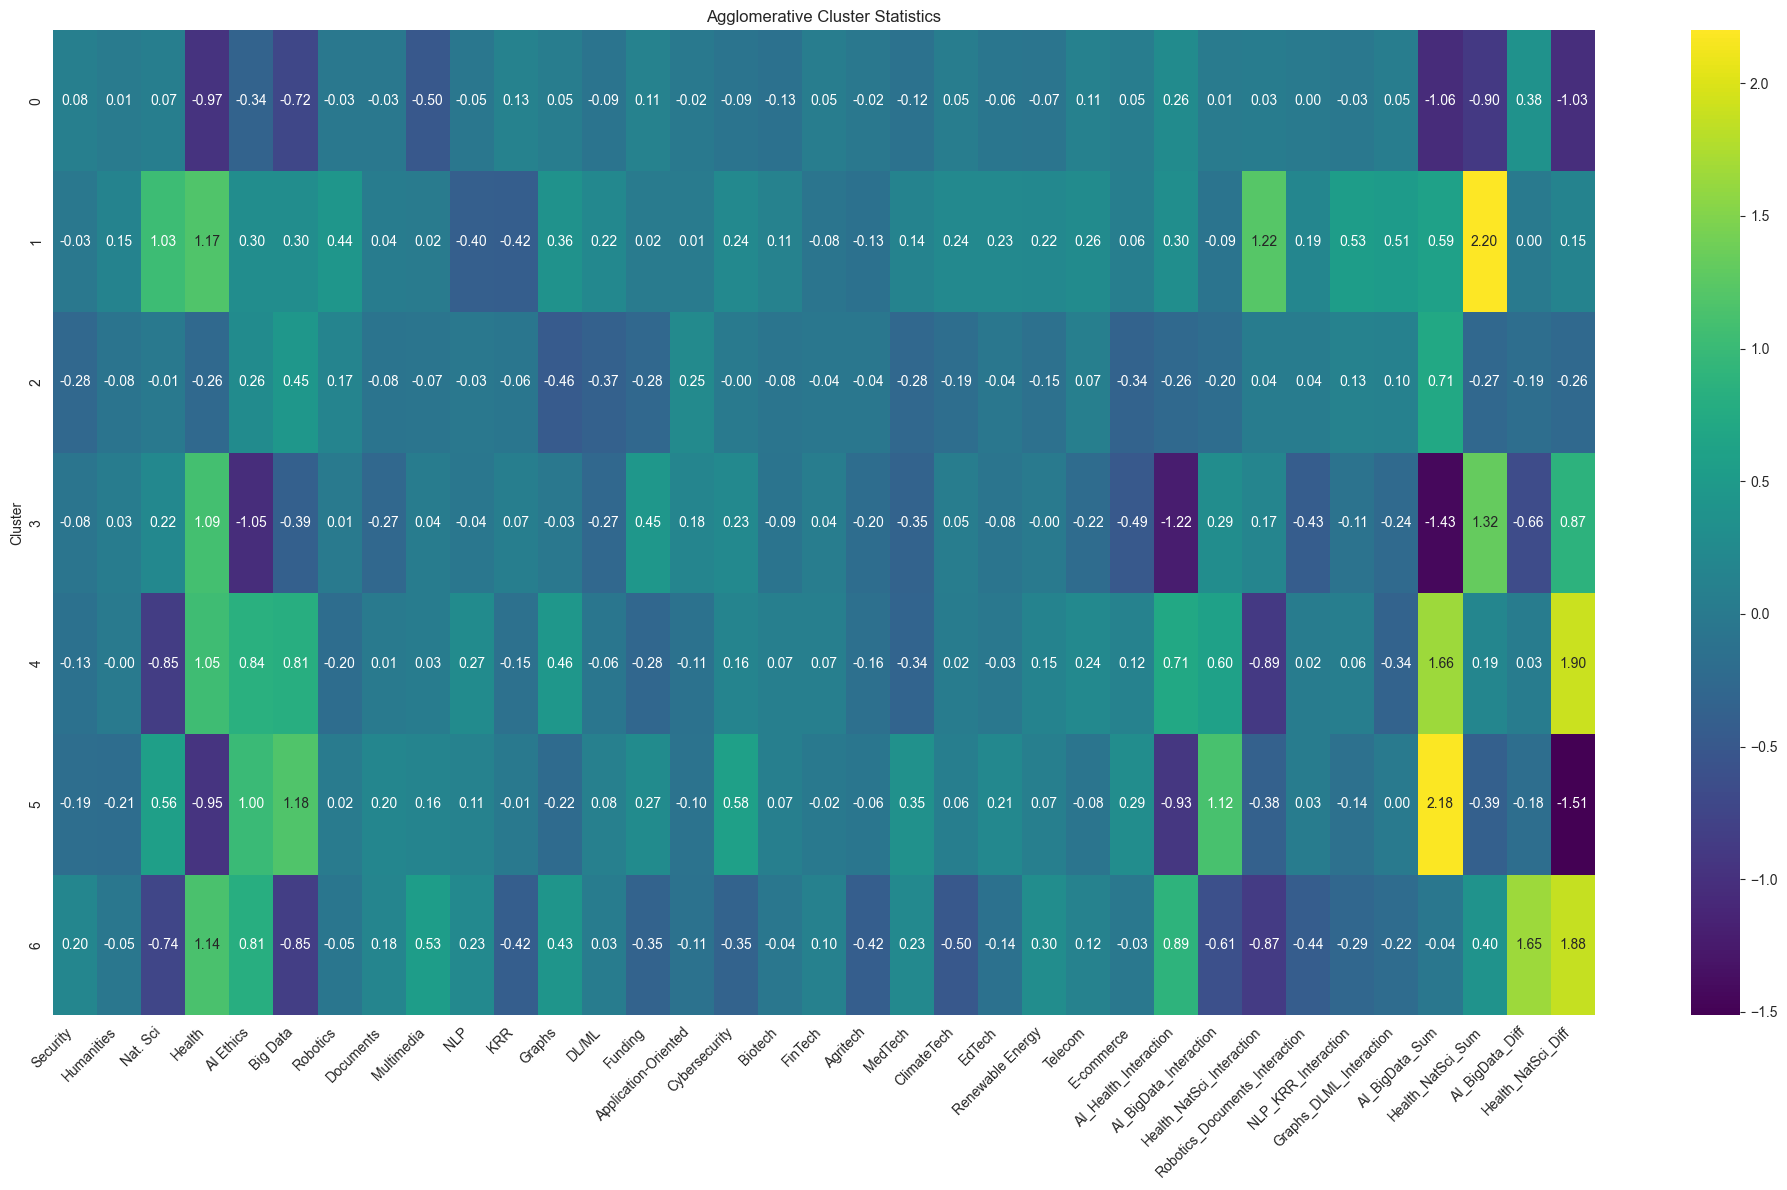

In [70]:
cluster_stats_kmeans = compute_cluster_statistics(test_data, best_labels_kmeans)
cluster_stats_agg = compute_cluster_statistics(test_data, best_labels_agg)

# Plot the cluster statistics
plot_cluster_statistics(cluster_stats_kmeans, title='KMeans Cluster Statistics')
plot_cluster_statistics(cluster_stats_agg, title='Agglomerative Cluster Statistics')

In [72]:
from sklearn.model_selection import KFold
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def cross_validate_ensemble_model(autoencoder_func, train_data, n_splits=5, num_autoencoders=3):
    kf = KFold(n_splits=n_splits)
    fold = 1
    all_histories = []
    
    for train_index, val_index in kf.split(train_data):
        kf_train_data, val_data = train_data.iloc[train_index], train_data.iloc[val_index]
        autoencoders, histories = autoencoder_func(num_autoencoders, input_dim, best_params, kf_train_data)
        combined_encoding = ensemble_encoding(autoencoders, val_data)
        
        # KMeans Clustering
        optimal_clusters_kmeans = find_optimal_clusters(combined_encoding, apply_kmeans_clustering, range(2, 11))
        best_labels_kmeans = apply_kmeans_clustering(combined_encoding, optimal_clusters_kmeans)
        silhouette_avg_kmeans, davies_bouldin_kmeans = evaluate_clustering(combined_encoding, best_labels_kmeans)
        logging.info(f'Fold {fold} - KMeans Silhouette Score: {silhouette_avg_kmeans}, Davies-Bouldin Score: {davies_bouldin_kmeans}')
        
        # Agglomerative Clustering
        optimal_clusters_agg = find_optimal_clusters(combined_encoding, apply_agglomerative_clustering, range(2, 11))
        best_labels_agg = apply_agglomerative_clustering(combined_encoding, optimal_clusters_agg)
        silhouette_avg_agg, davies_bouldin_agg = evaluate_clustering(combined_encoding, best_labels_agg)
        logging.info(f'Fold {fold} - Agglomerative Silhouette Score: {silhouette_avg_agg}, Davies-Bouldin Score: {davies_bouldin_agg}')
        
        all_histories.extend(histories)
        fold += 1

    plot_training_history(all_histories)


Epoch 1/100
10/10 - 2s - 167ms/step - loss: 1.3965 - val_loss: 1.3537 - learning_rate: 0.0010
Epoch 2/100
10/10 - 0s - 3ms/step - loss: 1.3714 - val_loss: 1.3375 - learning_rate: 0.0010
Epoch 3/100
10/10 - 0s - 3ms/step - loss: 1.3433 - val_loss: 1.3220 - learning_rate: 0.0010
Epoch 4/100
10/10 - 0s - 6ms/step - loss: 1.3252 - val_loss: 1.3071 - learning_rate: 0.0010
Epoch 5/100
10/10 - 0s - 4ms/step - loss: 1.3083 - val_loss: 1.2927 - learning_rate: 0.0010
Epoch 6/100
10/10 - 0s - 4ms/step - loss: 1.2903 - val_loss: 1.2783 - learning_rate: 0.0010
Epoch 7/100
10/10 - 0s - 4ms/step - loss: 1.2737 - val_loss: 1.2637 - learning_rate: 0.0010
Epoch 8/100
10/10 - 0s - 3ms/step - loss: 1.2583 - val_loss: 1.2492 - learning_rate: 0.0010
Epoch 9/100
10/10 - 0s - 8ms/step - loss: 1.2395 - val_loss: 1.2343 - learning_rate: 0.0010
Epoch 10/100
10/10 - 0s - 23ms/step - loss: 1.2201 - val_loss: 1.2195 - learning_rate: 0.0010
Epoch 11/100
10/10 - 0s - 8ms/step - loss: 1.2060 - val_loss: 1.2050 - learn

2024-07-12 10:54:41,129 - INFO - Fold 1 - KMeans Silhouette Score: 0.21850380301475525, Davies-Bouldin Score: 1.544433130956686


Silhouette Scores: [0.28135225, 0.26827675, 0.22970796, 0.2185038, 0.20661493, 0.1842691, 0.1765304, 0.17346726, 0.18385288]
Davies-Bouldin Scores: [1.2888346582758912, 1.3154812858633669, 1.573880914661467, 1.544433130956686, 1.4911001751387245, 1.4670432370995694, 1.4742109715695901, 1.510469463113595, 1.3972214215292322]
Inertia Scores: [201.5228271484375, 153.2358856201172, 144.71559143066406, 128.4537353515625, 115.04496765136719, 108.02417755126953, 100.0340576171875, 97.05429077148438, 86.147216796875]
Optimal number of clusters determined: 5


2024-07-12 10:54:41,170 - INFO - Fold 1 - Agglomerative Silhouette Score: 0.1948574185371399, Davies-Bouldin Score: 1.569071005229556


Silhouette Scores: [0.28066486, 0.2588988, 0.23577437, 0.19485742, 0.15862758, 0.15413734, 0.161545, 0.14366953, 0.15638903]
Davies-Bouldin Scores: [1.3198547527516438, 1.3412623484717188, 1.4246322392868989, 1.569071005229556, 1.6314751703690302, 1.5777068794136662, 1.460702119739687, 1.4920010452371268, 1.4477778291106618]
Inertia Scores: [201.5228271484375, 153.2358856201172, 144.71559143066406, 128.4537353515625, 115.04496765136719, 108.02417755126953, 100.0340576171875, 97.05429077148438, 86.147216796875]
Optimal number of clusters determined: 5
Epoch 1/100
10/10 - 1s - 121ms/step - loss: 1.3742 - val_loss: 1.3402 - learning_rate: 0.0010
Epoch 2/100
10/10 - 0s - 6ms/step - loss: 1.3438 - val_loss: 1.3291 - learning_rate: 0.0010
Epoch 3/100
10/10 - 0s - 4ms/step - loss: 1.3221 - val_loss: 1.3177 - learning_rate: 0.0010
Epoch 4/100
10/10 - 0s - 4ms/step - loss: 1.3045 - val_loss: 1.3065 - learning_rate: 0.0010
Epoch 5/100
10/10 - 0s - 4ms/step - loss: 1.2812 - val_loss: 1.2949 - lea

2024-07-12 10:54:57,902 - INFO - Fold 2 - KMeans Silhouette Score: 0.21144726872444153, Davies-Bouldin Score: 1.28671526489457
2024-07-12 10:54:57,939 - INFO - Fold 2 - Agglomerative Silhouette Score: 0.18013305962085724, Davies-Bouldin Score: 1.3858986570141207


Silhouette Scores: [0.31762618, 0.25876075, 0.1892086, 0.19764695, 0.21144727, 0.20354867, 0.1950858, 0.19942695, 0.1840938]
Davies-Bouldin Scores: [1.3863856468104039, 1.316793641135675, 1.4970998315863697, 1.416096257328182, 1.28671526489457, 1.3513497936426173, 1.39193537292098, 1.3770395615454285, 1.4365277350632881]
Inertia Scores: [189.16323852539062, 146.08438110351562, 133.0492401123047, 117.69168090820312, 99.852294921875, 91.94415283203125, 85.51863098144531, 81.60099792480469, 79.72650146484375]
Optimal number of clusters determined: 6
Silhouette Scores: [0.27178037, 0.2409502, 0.21131083, 0.18167523, 0.18013306, 0.19310343, 0.17381364, 0.19037834, 0.19717321]
Davies-Bouldin Scores: [1.4940447898490492, 1.3397443628668935, 1.3010008642501985, 1.3920859182631244, 1.3858986570141207, 1.3214451571926862, 1.3919850930548565, 1.30004932137678, 1.2556997282394562]
Inertia Scores: [189.16323852539062, 146.08438110351562, 133.0492401123047, 117.69168090820312, 99.852294921875, 91.94

2024-07-12 10:55:26,855 - INFO - Fold 3 - KMeans Silhouette Score: 0.2779591679573059, Davies-Bouldin Score: 1.2594915641650706


Silhouette Scores: [0.25118327, 0.28999436, 0.27795917, 0.25628275, 0.23536845, 0.22739908, 0.22327419, 0.22549525, 0.21641031]
Davies-Bouldin Scores: [1.5481023392143207, 1.2107262144821067, 1.2594915641650706, 1.3122662049609464, 1.33107781387531, 1.352422589291282, 1.2480794127975852, 1.3068793788443727, 1.3167445018939348]
Inertia Scores: [205.4520721435547, 149.20855712890625, 129.24000549316406, 117.42094421386719, 106.55702209472656, 96.92171478271484, 87.38297271728516, 82.2884521484375, 80.3230972290039]
Optimal number of clusters determined: 4


2024-07-12 10:55:26,899 - INFO - Fold 3 - Agglomerative Silhouette Score: 0.20438644289970398, Davies-Bouldin Score: 1.3943256256507697


Silhouette Scores: [0.2523325, 0.23265198, 0.20438644, 0.20733757, 0.18993169, 0.18282029, 0.18878758, 0.19429341, 0.20919743]
Davies-Bouldin Scores: [1.528857656312326, 1.424111570772685, 1.3943256256507697, 1.4350135326907678, 1.322873879787226, 1.4182050714385732, 1.3570073466964307, 1.3168968383521265, 1.2781039715159035]
Inertia Scores: [205.4520721435547, 149.20855712890625, 129.24000549316406, 117.42094421386719, 106.55702209472656, 96.92171478271484, 87.38297271728516, 82.2884521484375, 80.3230972290039]
Optimal number of clusters determined: 4
Epoch 1/100
10/10 - 4s - 404ms/step - loss: 1.3849 - val_loss: 1.3703 - learning_rate: 0.0010
Epoch 2/100
10/10 - 0s - 3ms/step - loss: 1.3604 - val_loss: 1.3563 - learning_rate: 0.0010
Epoch 3/100
10/10 - 0s - 3ms/step - loss: 1.3369 - val_loss: 1.3425 - learning_rate: 0.0010
Epoch 4/100
10/10 - 0s - 3ms/step - loss: 1.3142 - val_loss: 1.3285 - learning_rate: 0.0010
Epoch 5/100
10/10 - 0s - 4ms/step - loss: 1.2939 - val_loss: 1.3134 - l

2024-07-12 10:55:42,736 - INFO - Fold 4 - KMeans Silhouette Score: 0.22745735943317413, Davies-Bouldin Score: 1.3399831024340934


Silhouette Scores: [0.2968715, 0.18284957, 0.22745736, 0.19994867, 0.15605807, 0.16329053, 0.18543537, 0.1896163, 0.18712635]
Davies-Bouldin Scores: [1.4808199079601083, 1.4826802276253757, 1.3399831024340934, 1.3953400831140166, 1.5084492679504538, 1.550584535886237, 1.4434941754532988, 1.3980247399496522, 1.4004257384780914]
Inertia Scores: [242.84144592285156, 208.74026489257812, 158.02459716796875, 144.1548309326172, 139.5625, 127.08378601074219, 114.61770629882812, 106.1263656616211, 100.63430786132812]
Optimal number of clusters determined: 4
Silhouette Scores: [0.23376007, 0.2526984, 0.19026223, 0.19383655, 0.1723715, 0.18299624, 0.1814678, 0.17101356, 0.163389]
Davies-Bouldin Scores: [1.707882330377045, 1.2642789001194106, 1.4015776137283114, 1.4635886728880503, 1.4887316611000943, 1.400453526817707, 1.3709996293559075, 1.3454220627786724, 1.3556847609765303]
Inertia Scores: [242.84144592285156, 208.74026489257812, 158.02459716796875, 144.1548309326172, 139.5625, 127.0837860107

2024-07-12 10:55:42,766 - INFO - Fold 4 - Agglomerative Silhouette Score: 0.19026222825050354, Davies-Bouldin Score: 1.4015776137283114


Epoch 1/100
10/10 - 1s - 106ms/step - loss: 1.3829 - val_loss: 1.3540 - learning_rate: 0.0010
Epoch 2/100
10/10 - 0s - 3ms/step - loss: 1.3554 - val_loss: 1.3456 - learning_rate: 0.0010
Epoch 3/100
10/10 - 0s - 3ms/step - loss: 1.3313 - val_loss: 1.3363 - learning_rate: 0.0010
Epoch 4/100
10/10 - 0s - 3ms/step - loss: 1.3129 - val_loss: 1.3261 - learning_rate: 0.0010
Epoch 5/100
10/10 - 0s - 3ms/step - loss: 1.2872 - val_loss: 1.3147 - learning_rate: 0.0010
Epoch 6/100
10/10 - 0s - 3ms/step - loss: 1.2702 - val_loss: 1.3021 - learning_rate: 0.0010
Epoch 7/100
10/10 - 0s - 3ms/step - loss: 1.2545 - val_loss: 1.2882 - learning_rate: 0.0010
Epoch 8/100
10/10 - 0s - 3ms/step - loss: 1.2341 - val_loss: 1.2732 - learning_rate: 0.0010
Epoch 9/100
10/10 - 0s - 3ms/step - loss: 1.2144 - val_loss: 1.2578 - learning_rate: 0.0010
Epoch 10/100
10/10 - 0s - 2ms/step - loss: 1.1981 - val_loss: 1.2418 - learning_rate: 0.0010
Epoch 11/100
10/10 - 0s - 3ms/step - loss: 1.1868 - val_loss: 1.2253 - learni

2024-07-12 10:55:54,215 - INFO - Fold 5 - KMeans Silhouette Score: 0.22356319427490234, Davies-Bouldin Score: 1.3802172083062068
2024-07-12 10:55:54,242 - INFO - Fold 5 - Agglomerative Silhouette Score: 0.2395337074995041, Davies-Bouldin Score: 1.3915371919672181


Silhouette Scores: [0.2447679, 0.2896713, 0.21384363, 0.2235632, 0.1934957, 0.2166481, 0.21371984, 0.20238957, 0.19926095]
Davies-Bouldin Scores: [1.613996399786288, 1.258776012360297, 1.4346849877322427, 1.3802172083062068, 1.4371542402472866, 1.3774328254137393, 1.3367209711618662, 1.3358068033763366, 1.3129558456586614]
Inertia Scores: [172.41510009765625, 124.19161987304688, 111.93437957763672, 98.03691101074219, 94.15772247314453, 81.90421295166016, 78.51394653320312, 73.66136169433594, 68.53626251220703]
Optimal number of clusters determined: 5
Silhouette Scores: [0.2757976, 0.23691745, 0.2508162, 0.23953371, 0.22031052, 0.19695537, 0.20086789, 0.18722391, 0.18144076]
Davies-Bouldin Scores: [1.462471236283687, 1.4228945546352156, 1.3482570356797217, 1.3915371919672181, 1.3954507739345956, 1.4065175142944581, 1.3107599816254076, 1.3503147072746826, 1.3687413182794976]
Inertia Scores: [172.41510009765625, 124.19161987304688, 111.93437957763672, 98.03691101074219, 94.15772247314453,

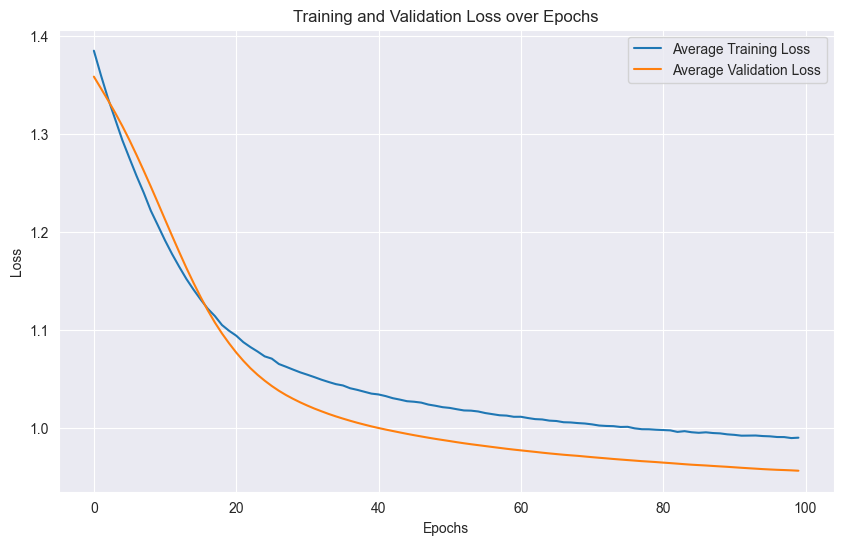

In [73]:
cross_validate_ensemble_model(train_multiple_autoencoders, train_data, n_splits=5, num_autoencoders=3)